### Visualizing the distribution of the observations

### Load the required libraries

In [3]:
#sc.stop()
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
#file_index='BBBSBBBB'
file_index='BSBSSSBB'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

Populating the interactive namespace from numpy and matplotlib
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
13081
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|     36.6| 31.9297| -82.6792|       TMAX|USC00095386|    14|[90 55 A0 56 38 5...|1946.0|BSBSSSBB|
|     36.6| 31.9297| -82.6792|       TMAX|USC00095386|     0|[B0 58 E0 55 B0 5...|1947.0|BSBSSSBB|
|     36.6| 31.9297| -82.6792|       TMAX|USC00095386|     1|[78 5B 98 5A A0 5...|1948.0|BSBSSSBB|
|     36.6| 31.9297| -82.6792|       TMAX|USC00095386|    32|[70 5A 98 5A 48 5...|1950.0|BSBSSSBB|
|     36.6| 31.9297| -82.6792|       TMAX|USC00095386|     7|[00 58 90 59 C8 5...|1951.0|BSBSSSBB|
+---------+--------+---------+-----------+-----------+------+-------------

### Select data for a particular station and measurement type

In [4]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('TMAX','USC00095386')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(10)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)

SELECT * FROM weather
	WHERE measurement='TMAX' and station='USC00095386'
38 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|     36.6| 31.9297| -82.6792|       TMAX|USC00095386|    14|[90 55 A0 56 38 5...|1946.0|BSBSSSBB|
|     36.6| 31.9297| -82.6792|       TMAX|USC00095386|     0|[B0 58 E0 55 B0 5...|1947.0|BSBSSSBB|
|     36.6| 31.9297| -82.6792|       TMAX|USC00095386|     1|[78 5B 98 5A A0 5...|1948.0|BSBSSSBB|
|     36.6| 31.9297| -82.6792|       TMAX|USC00095386|    32|[70 5A 98 5A 48 5...|1950.0|BSBSSSBB|
|     36.6| 31.9297| -82.6792|       TMAX|USC00095386|     7|[00 58 90 59 C8 5...|1951.0|BSBSSSBB|
|     36.6| 31.9297| -82.6792|       TMAX|USC00095386|     9|[D0 5B 14 5C 2C 5...|1952.0|BSBSSSBB|
|     36.6| 31.9297| -82.67

(38, 365)

### Script for plotting yearly plots

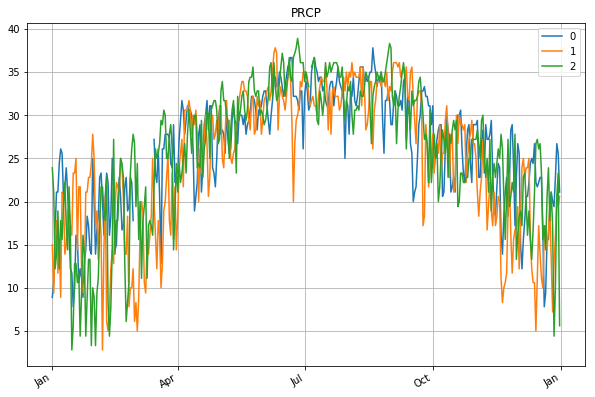

In [5]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T[:3,:].transpose(),fig,ax,title='PRCP')
#title('A sample of graphs');

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [6]:
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]#ttcses
        j+=1
        func(m,fig,axis)
        
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)
    

/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


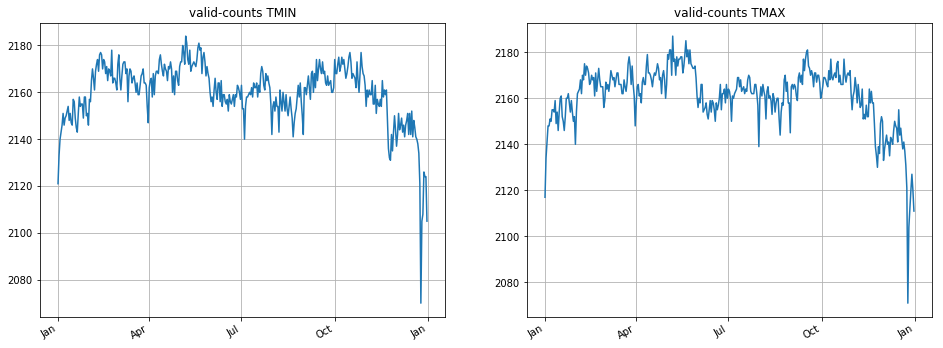

In [7]:
plot_pair(['TMIN','TMAX'],plot_valid)

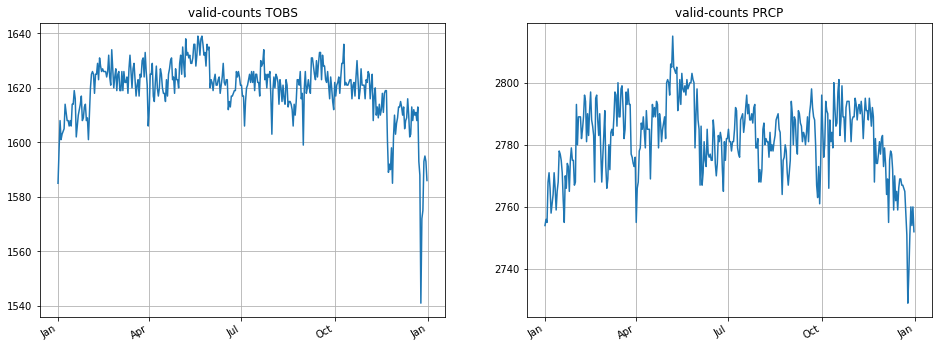

In [8]:
plot_pair(['TOBS','PRCP'],plot_valid)

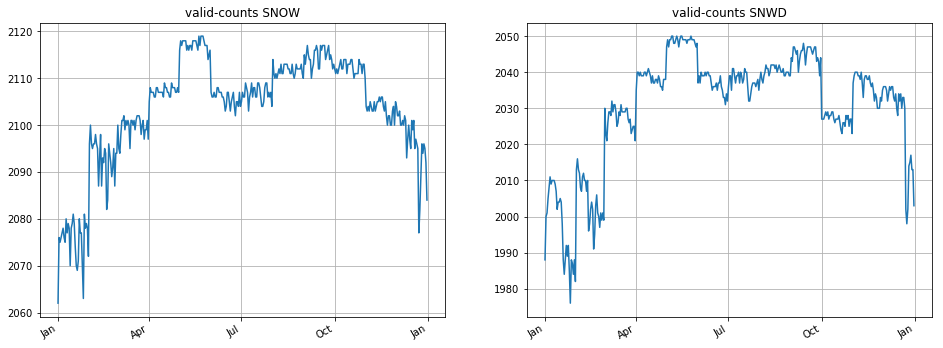

In [9]:
plot_pair(['SNOW', 'SNWD'],plot_valid)

### Plots of mean and std of observations

In [32]:
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean']
    std=np.sqrt(STAT[m]['Var'])
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m, labels=['mean-std','mean','mean+std'])
    
#This shows mean and sd across all years and stations 

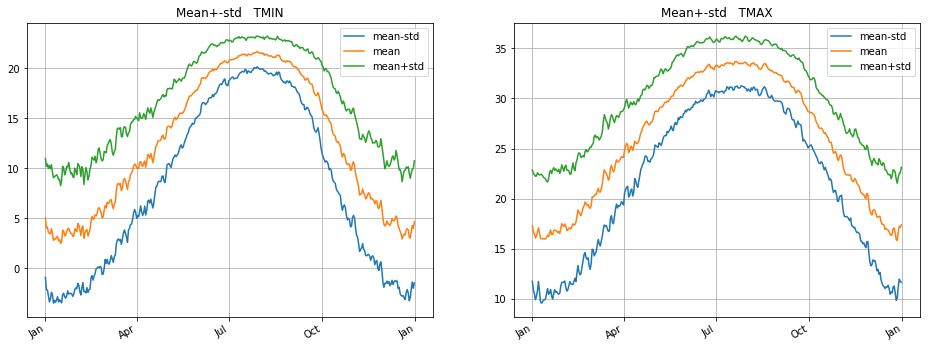

In [20]:
plot_pair(['TMIN','TMAX'],plot_mean_std)

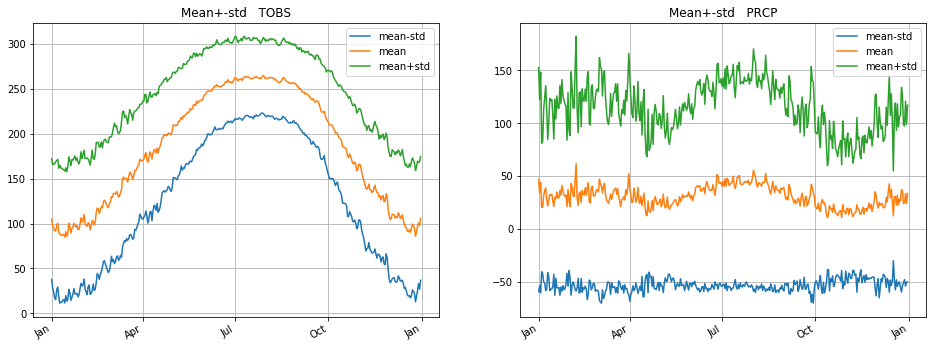

In [33]:
plot_pair(['TOBS','PRCP'],plot_mean_std)


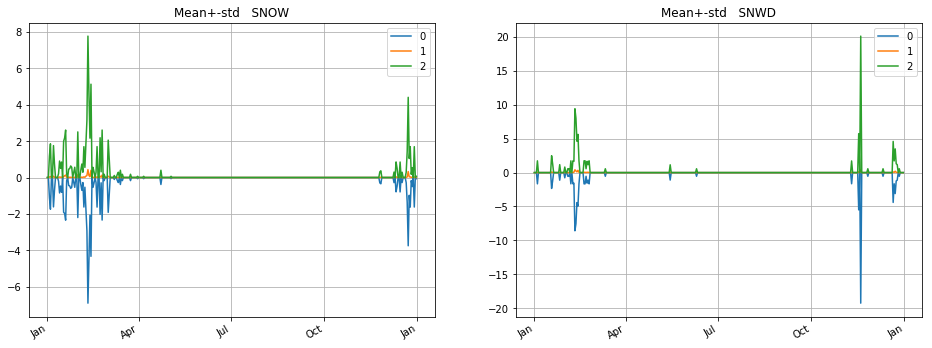

In [12]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)

### plotting top 3 eigenvectors

In [45]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

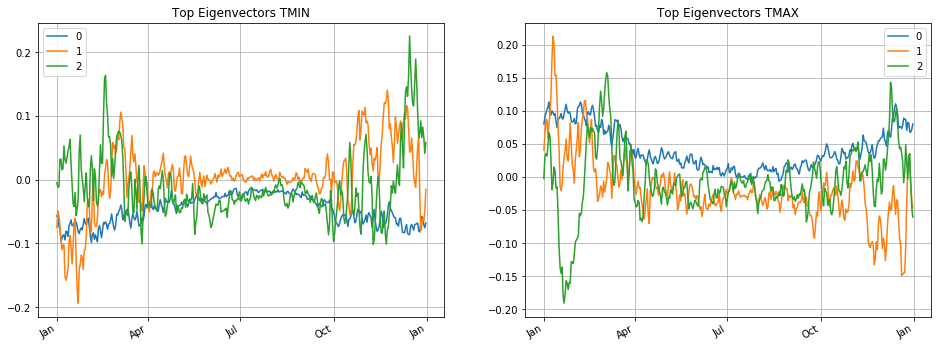

In [46]:
plot_pair(['TMIN','TMAX'],plot_eigen)

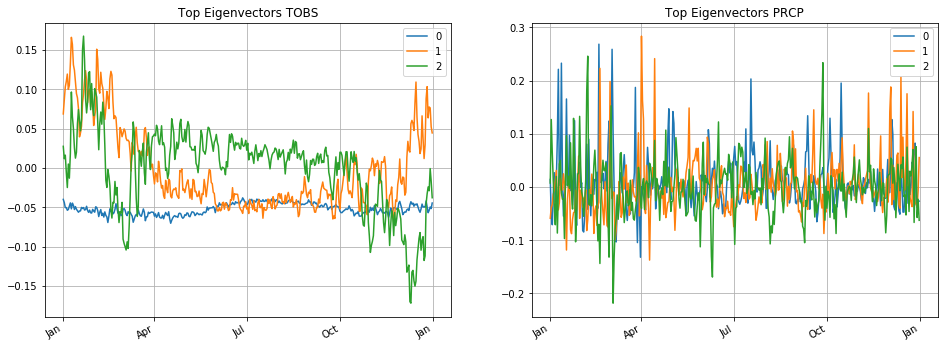

In [47]:
plot_pair(['TOBS','PRCP'],plot_eigen)

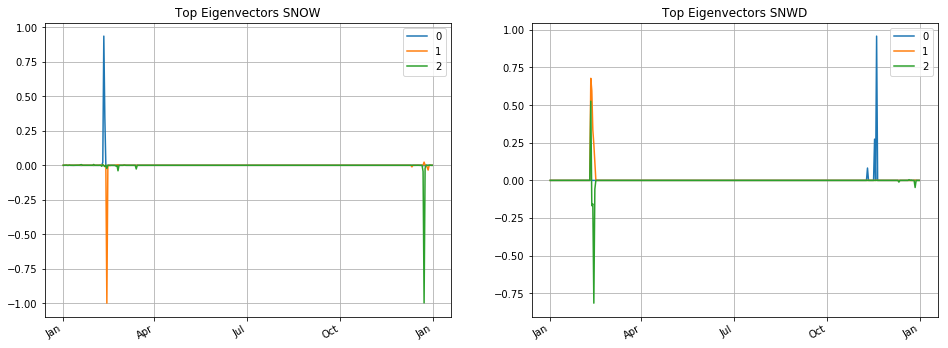

In [48]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

### Script for plotting percentage of variance explained

In [24]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

In [29]:
(STAT['TOBS']['eigval'])

array([  6.10384713e+05,   3.72796745e+04,   2.67757866e+04,
         2.27420035e+04,   2.16031457e+04,   1.87396408e+04,
         1.70154456e+04,   1.63358370e+04,   1.55952348e+04,
         1.54904406e+04,   1.49154189e+04,   1.41753099e+04,
         1.34260978e+04,   1.20982102e+04,   1.19788013e+04,
         1.15978877e+04,   1.12067078e+04,   1.07571654e+04,
         1.05243269e+04,   1.02724877e+04,   9.66847145e+03,
         9.45163481e+03,   9.30815274e+03,   8.34852454e+03,
         8.06558010e+03,   8.23000873e+03,   8.19752800e+03,
         7.69050240e+03,   7.44368151e+03,   7.36642774e+03,
         7.05285157e+03,   6.88654529e+03,   6.73747770e+03,
         6.54693161e+03,   6.51210359e+03,   6.13464759e+03,
         5.94050693e+03,  -2.55789515e+03,   5.57966934e+03,
         5.56144567e+03,   5.38718111e+03,   5.24230567e+03,
         5.14178640e+03,   4.96805086e+03,   4.89173098e+03,
         4.80822474e+03,   4.71540020e+03,   4.60014593e+03,
         4.39898349e+03,

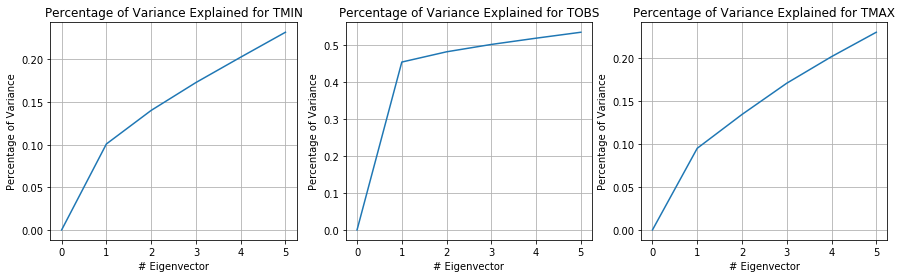

In [30]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1

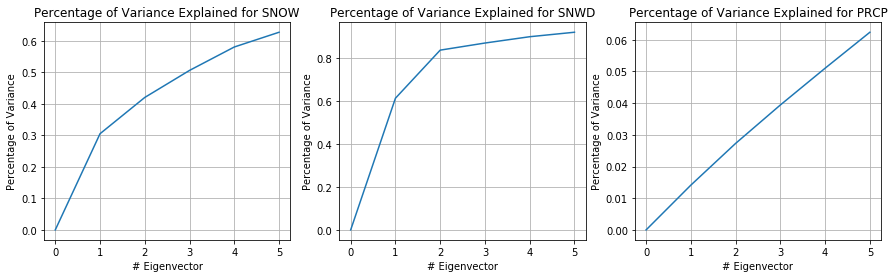

In [31]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

In [19]:
#sc.stop()